In [1]:
using Pkg
Pkg.activate("../QControl")
Pkg.instantiate()

  Activating project at `~/crostini/QControl.jl/QControl`


# Imports

In [2]:
import QControl

┌ Info: Precompiling QControl [edd81335-bcb3-4e33-9681-20bc820459a6]
└ @ Base loading.jl:1423


In [3]:
const QC = QControl;

In [4]:
using QuantumOptics
using PyPlot
using Altro
using ForwardDiff
using LinearAlgebra
using SparseArrays
using RobotDynamics
using TrajectoryOptimization
using StaticArrays
using ForwardDiff
using FiniteDiff
const TO = TrajectoryOptimization
const RD = RobotDynamics

RobotDynamics

# Cavity-Qubit System Setup

In [5]:
# Define bases for cavity (Fock) and atom (Spin-1/2)
const N_CAVITY = 20
const N_QUBIT = 2

bq = SpinBasis(1//2)
bc = FockBasis(N_CAVITY - 1)
bfull = bc ⊗ bq
DAC_time_resolution = 1 # ns


# constants (in GHz = cycles / ns)
α = .4
K = 1e-5
χ = 2e-3
D = 1e-3

# operators
a = destroy(bc) ⊗ one(bq)
σ⁻ = one(bc) ⊗ sigmam(bq) # up -> down, equivalent to creation op
ad = dagger(a)
σ⁺ = dagger(σ⁻)

# base hamiltonian
H₀ = (α/2) * σ⁻ * σ⁻ * σ⁺ * σ⁺
H₀ += (K/2) * ad * ad * a * a
H₀ += χ * ad * a * σ⁻ * σ⁺
H₀ *= 2*π
Hcs = [2*π*D*(σ⁺ + σ⁻), im*2*π*D*(σ⁺ + σ⁻), 2*π*D*(a+ad), im*2*π*(a - ad)];

# binomial code
binomial = Dict("z+" => normalize(fockstate(bc,0) + fockstate(bc,4)), "z-" => fockstate(bc, 2))

# Quantum states
ψi = [fockstate(bc, 0) ⊗ spinup(bq)]
ψt = [binomial["z+"] ⊗ spinup(bq)]

1-element Vector{Ket{CompositeBasis{Vector{Int64}, Tuple{FockBasis{Int64}, SpinBasis{1//2, Int64}}}, Vector{ComplexF64}}}:
 Ket(dim=40)
  basis: [Fock(cutoff=19) ⊗ Spin(1/2)]
 0.7071067811865475 + 0.0im
                0.0 + 0.0im
                0.0 + 0.0im
                0.0 + 0.0im
 0.7071067811865475 + 0.0im
                0.0 + 0.0im
                0.0 + 0.0im
                0.0 + 0.0im
                0.0 + 0.0im
                0.0 + 0.0im
                0.0 + 0.0im
                0.0 + 0.0im
                0.0 + 0.0im
                    ⋮
                0.0 + 0.0im
                0.0 + 0.0im
                0.0 + 0.0im
                0.0 + 0.0im
                0.0 + 0.0im
                0.0 + 0.0im
                0.0 + 0.0im
                0.0 + 0.0im
                0.0 + 0.0im
                0.0 + 0.0im
                0.0 + 0.0im
                0.0 + 0.0im

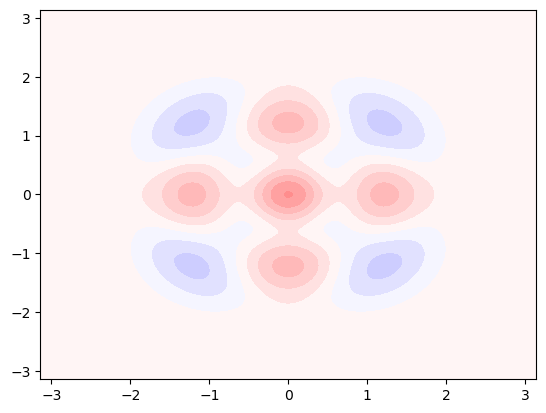

PyObject <matplotlib.contour.QuadContourSet object at 0x168f56820>

In [6]:
res = 101
wx=collect(range(-π, stop=π, length=2res))
wy=collect(range(-π, stop=π, length=2res))
Wρ = wigner(binomial["z+"], wx, wy)
contourf(wx,wy,Wρ, cmap="seismic", vmin = -1, vmax = 1)

In [7]:
RD.state_dim(::QC.QuantumState), RD.control_dim(::QC.QuantumState), dynamics_func, ψi_state, ψt_state = QC.gen_LQR_params(bfull, H₀, Hcs, ψi, ψt)
RD.dynamics(qs::QC.QuantumState,x,u) = dynamics_func(qs::QC.QuantumState,x,u)
;

In [8]:
model = QC.QuantumState()
state_dim = RD.state_dim(model)
control_dim = RD.control_dim(model)

N = 1001 # number of time steps
tf = 3.0 # ns, total time
dt = tf / (N-1) # time step


Q = zeros(state_dim, state_dim)
R = Matrix(0.0001*I, control_dim, control_dim)

I_matrix = Matrix(1.0I, state_dim, state_dim)
Qf = (I_matrix - ψt_state*transpose(QC.conj_isomorphism(ψt_state)))
# ⟨ψf|Qf|ψf⟩ = ⟨ψf|(I - |ψt⟩⟨ψt|)|ψf⟩ = 1 - |⟨ψf|ψt⟩|^2

obj = LQRObjective(Q,R,Qf,ψt_state,N);

In [9]:
# Add in normalization constraint and goal constraint
cons = ConstraintList(state_dim, control_dim, N)
normcon = NormConstraint(state_dim, control_dim, 1.0, Equality(), :state)
add_constraint!(cons, normcon, N)

goalcon = GoalConstraint(ψt_state)
add_constraint!(cons, goalcon, N)

In [10]:
prob = Problem(model, obj, ψi_state, tf, xf=ψt_state, integration=RD.RK4(model), constraints=cons);

In [11]:
initial_controls!(prob, [@SVector rand(control_dim) for k = 1:N-1])
rollout!(prob)   # simulate the system forward in time with the new controls

In [12]:
# Set up solver options
opts = SolverOptions()
opts.cost_tolerance = 1e-8

# Create a solver, adding in additional options
solver = ALTROSolver(prob, opts, show_summary=false);

In [13]:
solve!(solver);

┌ Warning: Backwardpass cholesky failed at time step 1000
└ @ Altro /Users/shoumikdc/.julia/packages/Altro/jipqO/src/ilqr/backwardpass.jl:87
┌ Warning: Backwardpass cholesky failed at time step 1000
└ @ Altro /Users/shoumikdc/.julia/packages/Altro/jipqO/src/ilqr/backwardpass.jl:87
┌ Warning: Backwardpass cholesky failed at time step 1000
└ @ Altro /Users/shoumikdc/.julia/packages/Altro/jipqO/src/ilqr/backwardpass.jl:87
┌ Warning: Backwardpass cholesky failed at time step 1000
└ @ Altro /Users/shoumikdc/.julia/packages/Altro/jipqO/src/ilqr/backwardpass.jl:87
┌ Warning: Backwardpass cholesky failed at time step 1000
└ @ Altro /Users/shoumikdc/.julia/packages/Altro/jipqO/src/ilqr/backwardpass.jl:87
┌ Warning: Backwardpass cholesky failed at time step 1000
└ @ Altro /Users/shoumikdc/.julia/packages/Altro/jipqO/src/ilqr/backwardpass.jl:87
┌ Warning: Backwardpass cholesky failed at time step 1000
└ @ Altro /Users/shoumikdc/.julia/packages/Altro/jipqO/src/ilqr/backwardpass.jl:87
┌ Warning: Ba

┌ Warning: Backwardpass cholesky failed at time step 1000
└ @ Altro /Users/shoumikdc/.julia/packages/Altro/jipqO/src/ilqr/backwardpass.jl:87
┌ Warning: Backwardpass cholesky failed at time step 1000
└ @ Altro /Users/shoumikdc/.julia/packages/Altro/jipqO/src/ilqr/backwardpass.jl:87
┌ Warning: Backwardpass cholesky failed at time step 1000
└ @ Altro /Users/shoumikdc/.julia/packages/Altro/jipqO/src/ilqr/backwardpass.jl:87
┌ Warning: Backwardpass cholesky failed at time step 1000
└ @ Altro /Users/shoumikdc/.julia/packages/Altro/jipqO/src/ilqr/backwardpass.jl:87
┌ Warning: Backwardpass cholesky failed at time step 1000
└ @ Altro /Users/shoumikdc/.julia/packages/Altro/jipqO/src/ilqr/backwardpass.jl:87
┌ Warning: Backwardpass cholesky failed at time step 1000
└ @ Altro /Users/shoumikdc/.julia/packages/Altro/jipqO/src/ilqr/backwardpass.jl:87
┌ Warning: Backwardpass cholesky failed at time step 1000
└ @ Altro /Users/shoumikdc/.julia/packages/Altro/jipqO/src/ilqr/backwardpass.jl:87
┌ Warning: Ba

┌ Warning: Backwardpass cholesky failed at time step 1000
└ @ Altro /Users/shoumikdc/.julia/packages/Altro/jipqO/src/ilqr/backwardpass.jl:87
┌ Warning: Backwardpass cholesky failed at time step 1000
└ @ Altro /Users/shoumikdc/.julia/packages/Altro/jipqO/src/ilqr/backwardpass.jl:87
┌ Warning: Backwardpass cholesky failed at time step 1000
└ @ Altro /Users/shoumikdc/.julia/packages/Altro/jipqO/src/ilqr/backwardpass.jl:87
┌ Warning: Backwardpass cholesky failed at time step 1000
└ @ Altro /Users/shoumikdc/.julia/packages/Altro/jipqO/src/ilqr/backwardpass.jl:87
┌ Warning: Backwardpass cholesky failed at time step 1000
└ @ Altro /Users/shoumikdc/.julia/packages/Altro/jipqO/src/ilqr/backwardpass.jl:87
┌ Warning: Backwardpass cholesky failed at time step 1000
└ @ Altro /Users/shoumikdc/.julia/packages/Altro/jipqO/src/ilqr/backwardpass.jl:87
┌ Warning: Backwardpass cholesky failed at time step 1000
└ @ Altro /Users/shoumikdc/.julia/packages/Altro/jipqO/src/ilqr/backwardpass.jl:87
┌ Warning: Ba

┌ Warning: Backwardpass cholesky failed at time step 999
└ @ Altro /Users/shoumikdc/.julia/packages/Altro/jipqO/src/ilqr/backwardpass.jl:87
┌ Warning: Backwardpass cholesky failed at time step 1000
└ @ Altro /Users/shoumikdc/.julia/packages/Altro/jipqO/src/ilqr/backwardpass.jl:87
┌ Warning: Backwardpass cholesky failed at time step 1000
└ @ Altro /Users/shoumikdc/.julia/packages/Altro/jipqO/src/ilqr/backwardpass.jl:87
┌ Warning: Backwardpass cholesky failed at time step 1000
└ @ Altro /Users/shoumikdc/.julia/packages/Altro/jipqO/src/ilqr/backwardpass.jl:87
┌ Warning: Backwardpass cholesky failed at time step 1000
└ @ Altro /Users/shoumikdc/.julia/packages/Altro/jipqO/src/ilqr/backwardpass.jl:87
┌ Warning: Backwardpass cholesky failed at time step 1000
└ @ Altro /Users/shoumikdc/.julia/packages/Altro/jipqO/src/ilqr/backwardpass.jl:87
┌ Warning: Backwardpass cholesky failed at time step 1000
└ @ Altro /Users/shoumikdc/.julia/packages/Altro/jipqO/src/ilqr/backwardpass.jl:87
┌ Warning: Bac

┌ Warning: Backwardpass cholesky failed at time step 1000
└ @ Altro /Users/shoumikdc/.julia/packages/Altro/jipqO/src/ilqr/backwardpass.jl:87
┌ Warning: Backwardpass cholesky failed at time step 1000
└ @ Altro /Users/shoumikdc/.julia/packages/Altro/jipqO/src/ilqr/backwardpass.jl:87
┌ Warning: Backwardpass cholesky failed at time step 1000
└ @ Altro /Users/shoumikdc/.julia/packages/Altro/jipqO/src/ilqr/backwardpass.jl:87
┌ Warning: Backwardpass cholesky failed at time step 1000
└ @ Altro /Users/shoumikdc/.julia/packages/Altro/jipqO/src/ilqr/backwardpass.jl:87
┌ Warning: Backwardpass cholesky failed at time step 1000
└ @ Altro /Users/shoumikdc/.julia/packages/Altro/jipqO/src/ilqr/backwardpass.jl:87
┌ Warning: Backwardpass cholesky failed at time step 1000
└ @ Altro /Users/shoumikdc/.julia/packages/Altro/jipqO/src/ilqr/backwardpass.jl:87
┌ Warning: Backwardpass cholesky failed at time step 1000
└ @ Altro /Users/shoumikdc/.julia/packages/Altro/jipqO/src/ilqr/backwardpass.jl:87
┌ Warning: Ba

┌ Warning: Backwardpass cholesky failed at time step 1000
└ @ Altro /Users/shoumikdc/.julia/packages/Altro/jipqO/src/ilqr/backwardpass.jl:87
┌ Warning: Backwardpass cholesky failed at time step 1000
└ @ Altro /Users/shoumikdc/.julia/packages/Altro/jipqO/src/ilqr/backwardpass.jl:87
┌ Warning: Backwardpass cholesky failed at time step 1000
└ @ Altro /Users/shoumikdc/.julia/packages/Altro/jipqO/src/ilqr/backwardpass.jl:87
┌ Warning: Backwardpass cholesky failed at time step 1000
└ @ Altro /Users/shoumikdc/.julia/packages/Altro/jipqO/src/ilqr/backwardpass.jl:87
┌ Warning: Backwardpass cholesky failed at time step 1000
└ @ Altro /Users/shoumikdc/.julia/packages/Altro/jipqO/src/ilqr/backwardpass.jl:87
┌ Warning: Backwardpass cholesky failed at time step 1000
└ @ Altro /Users/shoumikdc/.julia/packages/Altro/jipqO/src/ilqr/backwardpass.jl:87
┌ Warning: Backwardpass cholesky failed at time step 1000
└ @ Altro /Users/shoumikdc/.julia/packages/Altro/jipqO/src/ilqr/backwardpass.jl:87
┌ Warning: Ba

┌ Warning: Backwardpass cholesky failed at time step 1000
└ @ Altro /Users/shoumikdc/.julia/packages/Altro/jipqO/src/ilqr/backwardpass.jl:87
┌ Warning: Backwardpass cholesky failed at time step 1000
└ @ Altro /Users/shoumikdc/.julia/packages/Altro/jipqO/src/ilqr/backwardpass.jl:87
┌ Warning: Backwardpass cholesky failed at time step 1000
└ @ Altro /Users/shoumikdc/.julia/packages/Altro/jipqO/src/ilqr/backwardpass.jl:87
┌ Warning: Backwardpass cholesky failed at time step 1000
└ @ Altro /Users/shoumikdc/.julia/packages/Altro/jipqO/src/ilqr/backwardpass.jl:87
┌ Warning: Backwardpass cholesky failed at time step 1000
└ @ Altro /Users/shoumikdc/.julia/packages/Altro/jipqO/src/ilqr/backwardpass.jl:87
┌ Warning: Backwardpass cholesky failed at time step 1000
└ @ Altro /Users/shoumikdc/.julia/packages/Altro/jipqO/src/ilqr/backwardpass.jl:87
┌ Warning: Backwardpass cholesky failed at time step 1000
└ @ Altro /Users/shoumikdc/.julia/packages/Altro/jipqO/src/ilqr/backwardpass.jl:87
┌ Warning: Ba

┌ Warning: Backwardpass cholesky failed at time step 958
└ @ Altro /Users/shoumikdc/.julia/packages/Altro/jipqO/src/ilqr/backwardpass.jl:87
┌ Warning: Backwardpass cholesky failed at time step 1000
└ @ Altro /Users/shoumikdc/.julia/packages/Altro/jipqO/src/ilqr/backwardpass.jl:87
┌ Warning: Backwardpass cholesky failed at time step 1000
└ @ Altro /Users/shoumikdc/.julia/packages/Altro/jipqO/src/ilqr/backwardpass.jl:87
┌ Warning: Backwardpass cholesky failed at time step 1000
└ @ Altro /Users/shoumikdc/.julia/packages/Altro/jipqO/src/ilqr/backwardpass.jl:87
┌ Warning: Backwardpass cholesky failed at time step 1000
└ @ Altro /Users/shoumikdc/.julia/packages/Altro/jipqO/src/ilqr/backwardpass.jl:87
┌ Warning: Backwardpass cholesky failed at time step 1000
└ @ Altro /Users/shoumikdc/.julia/packages/Altro/jipqO/src/ilqr/backwardpass.jl:87
┌ Warning: Backwardpass cholesky failed at time step 1000
└ @ Altro /Users/shoumikdc/.julia/packages/Altro/jipqO/src/ilqr/backwardpass.jl:87
┌ Warning: Bac

┌ Warning: Backwardpass cholesky failed at time step 1000
└ @ Altro /Users/shoumikdc/.julia/packages/Altro/jipqO/src/ilqr/backwardpass.jl:87
┌ Warning: Backwardpass cholesky failed at time step 1000
└ @ Altro /Users/shoumikdc/.julia/packages/Altro/jipqO/src/ilqr/backwardpass.jl:87
┌ Warning: Backwardpass cholesky failed at time step 1000
└ @ Altro /Users/shoumikdc/.julia/packages/Altro/jipqO/src/ilqr/backwardpass.jl:87
┌ Warning: Backwardpass cholesky failed at time step 1000
└ @ Altro /Users/shoumikdc/.julia/packages/Altro/jipqO/src/ilqr/backwardpass.jl:87
┌ Warning: Backwardpass cholesky failed at time step 1000
└ @ Altro /Users/shoumikdc/.julia/packages/Altro/jipqO/src/ilqr/backwardpass.jl:87
┌ Warning: Backwardpass cholesky failed at time step 1000
└ @ Altro /Users/shoumikdc/.julia/packages/Altro/jipqO/src/ilqr/backwardpass.jl:87
┌ Warning: Backwardpass cholesky failed at time step 1000
└ @ Altro /Users/shoumikdc/.julia/packages/Altro/jipqO/src/ilqr/backwardpass.jl:87
┌ Warning: Ba

┌ Warning: Backwardpass cholesky failed at time step 1000
└ @ Altro /Users/shoumikdc/.julia/packages/Altro/jipqO/src/ilqr/backwardpass.jl:87
┌ Warning: Backwardpass cholesky failed at time step 1000
└ @ Altro /Users/shoumikdc/.julia/packages/Altro/jipqO/src/ilqr/backwardpass.jl:87
┌ Warning: Backwardpass cholesky failed at time step 1000
└ @ Altro /Users/shoumikdc/.julia/packages/Altro/jipqO/src/ilqr/backwardpass.jl:87
┌ Warning: Backwardpass cholesky failed at time step 1000
└ @ Altro /Users/shoumikdc/.julia/packages/Altro/jipqO/src/ilqr/backwardpass.jl:87
┌ Warning: Backwardpass cholesky failed at time step 1000
└ @ Altro /Users/shoumikdc/.julia/packages/Altro/jipqO/src/ilqr/backwardpass.jl:87
┌ Warning: Backwardpass cholesky failed at time step 1000
└ @ Altro /Users/shoumikdc/.julia/packages/Altro/jipqO/src/ilqr/backwardpass.jl:87
┌ Warning: Backwardpass cholesky failed at time step 1000
└ @ Altro /Users/shoumikdc/.julia/packages/Altro/jipqO/src/ilqr/backwardpass.jl:87
┌ Warning: Ba

┌ Warning: Backwardpass cholesky failed at time step 1000
└ @ Altro /Users/shoumikdc/.julia/packages/Altro/jipqO/src/ilqr/backwardpass.jl:87
┌ Warning: Backwardpass cholesky failed at time step 1000
└ @ Altro /Users/shoumikdc/.julia/packages/Altro/jipqO/src/ilqr/backwardpass.jl:87
┌ Warning: Backwardpass cholesky failed at time step 1000
└ @ Altro /Users/shoumikdc/.julia/packages/Altro/jipqO/src/ilqr/backwardpass.jl:87
┌ Warning: Backwardpass cholesky failed at time step 1000
└ @ Altro /Users/shoumikdc/.julia/packages/Altro/jipqO/src/ilqr/backwardpass.jl:87
┌ Warning: Backwardpass cholesky failed at time step 1000
└ @ Altro /Users/shoumikdc/.julia/packages/Altro/jipqO/src/ilqr/backwardpass.jl:87
┌ Warning: Backwardpass cholesky failed at time step 1000
└ @ Altro /Users/shoumikdc/.julia/packages/Altro/jipqO/src/ilqr/backwardpass.jl:87
┌ Warning: Backwardpass cholesky failed at time step 999
└ @ Altro /Users/shoumikdc/.julia/packages/Altro/jipqO/src/ilqr/backwardpass.jl:87
┌ Warning: Bac

┌ Warning: Backwardpass cholesky failed at time step 1000
└ @ Altro /Users/shoumikdc/.julia/packages/Altro/jipqO/src/ilqr/backwardpass.jl:87
┌ Warning: Backwardpass cholesky failed at time step 1000
└ @ Altro /Users/shoumikdc/.julia/packages/Altro/jipqO/src/ilqr/backwardpass.jl:87
┌ Warning: Backwardpass cholesky failed at time step 1000
└ @ Altro /Users/shoumikdc/.julia/packages/Altro/jipqO/src/ilqr/backwardpass.jl:87
┌ Warning: Backwardpass cholesky failed at time step 1000
└ @ Altro /Users/shoumikdc/.julia/packages/Altro/jipqO/src/ilqr/backwardpass.jl:87
┌ Warning: Backwardpass cholesky failed at time step 1000
└ @ Altro /Users/shoumikdc/.julia/packages/Altro/jipqO/src/ilqr/backwardpass.jl:87
┌ Warning: Backwardpass cholesky failed at time step 1000
└ @ Altro /Users/shoumikdc/.julia/packages/Altro/jipqO/src/ilqr/backwardpass.jl:87
┌ Warning: Backwardpass cholesky failed at time step 1000
└ @ Altro /Users/shoumikdc/.julia/packages/Altro/jipqO/src/ilqr/backwardpass.jl:87
┌ Warning: Ba

┌ Warning: Backwardpass cholesky failed at time step 1000
└ @ Altro /Users/shoumikdc/.julia/packages/Altro/jipqO/src/ilqr/backwardpass.jl:87
┌ Warning: Backwardpass cholesky failed at time step 1000
└ @ Altro /Users/shoumikdc/.julia/packages/Altro/jipqO/src/ilqr/backwardpass.jl:87
┌ Warning: Backwardpass cholesky failed at time step 1000
└ @ Altro /Users/shoumikdc/.julia/packages/Altro/jipqO/src/ilqr/backwardpass.jl:87
┌ Warning: Backwardpass cholesky failed at time step 1000
└ @ Altro /Users/shoumikdc/.julia/packages/Altro/jipqO/src/ilqr/backwardpass.jl:87
┌ Warning: Backwardpass cholesky failed at time step 1000
└ @ Altro /Users/shoumikdc/.julia/packages/Altro/jipqO/src/ilqr/backwardpass.jl:87
┌ Warning: Backwardpass cholesky failed at time step 1000
└ @ Altro /Users/shoumikdc/.julia/packages/Altro/jipqO/src/ilqr/backwardpass.jl:87
┌ Warning: Backwardpass cholesky failed at time step 1000
└ @ Altro /Users/shoumikdc/.julia/packages/Altro/jipqO/src/ilqr/backwardpass.jl:87
┌ Warning: Ba

┌ Warning: Backwardpass cholesky failed at time step 1000
└ @ Altro /Users/shoumikdc/.julia/packages/Altro/jipqO/src/ilqr/backwardpass.jl:87
┌ Warning: Backwardpass cholesky failed at time step 1000
└ @ Altro /Users/shoumikdc/.julia/packages/Altro/jipqO/src/ilqr/backwardpass.jl:87
┌ Warning: Backwardpass cholesky failed at time step 1000
└ @ Altro /Users/shoumikdc/.julia/packages/Altro/jipqO/src/ilqr/backwardpass.jl:87
┌ Warning: Backwardpass cholesky failed at time step 1000
└ @ Altro /Users/shoumikdc/.julia/packages/Altro/jipqO/src/ilqr/backwardpass.jl:87
┌ Warning: Backwardpass cholesky failed at time step 1000
└ @ Altro /Users/shoumikdc/.julia/packages/Altro/jipqO/src/ilqr/backwardpass.jl:87
┌ Warning: Backwardpass cholesky failed at time step 1000
└ @ Altro /Users/shoumikdc/.julia/packages/Altro/jipqO/src/ilqr/backwardpass.jl:87
┌ Warning: Backwardpass cholesky failed at time step 1000
└ @ Altro /Users/shoumikdc/.julia/packages/Altro/jipqO/src/ilqr/backwardpass.jl:87
┌ Warning: Ba

In [14]:
status(solver)

MAX_ITERATIONS_OUTER::TerminationStatus = 4

In [15]:
println("Number of iterations: ", iterations(solver))
println("Final cost: ", cost(solver))
println("Final constraint satisfaction: ", max_violation(solver)) #TODO: is 1 good??

Number of iterations: 30
Final cost: 1.0746124903539465e110
Final constraint satisfaction: 1.4660235266556581e51


In [17]:
X = states(solver)     # alternatively states(prob)
U = controls(solver)   # alternatively controls(prob)
Xv = Vector.(X)
Uv = Vector.(U)
Xcv = QC.real_to_complex_isomorphism.(Xv)
Ucv = QC.real_to_complex_isomorphism.(Uv)
Urv = map(cv -> real(cv)[1], Ucv)
Uiv = map(cv -> imag(cv)[1], Ucv)
Uav = map(cv -> norm(cv)[1], Ucv)
;

In [ ]:
szt = map(qv -> real(expect(sigmaz(bq_single),qv)), Xqv);

In [ ]:
ts = 1:N
plot(dt*ts, szt)
xlabel("Timestep (ns)")
ylabel("⟨ψ(t) | σ_z | ψ(t)⟩")
title("⟨σ_z(t)⟩")
grid("on")
tight_layout()

# 3ns * 1.2 = pi

In [ ]:
ts = 1:N-1
xlabel("Timestep (ns)")
ylabel("u(t)")
title("u(t)")
plot(dt*ts, Urv, label="Re[u(t)]")
plot(dt*ts, Uiv, label="Im[u(t)]")
plot(dt*ts, Uav, label="|u(t)|")
grid("on")
legend()
tight_layout()

# References

[1] https://arxiv.org/pdf/1707.01060.pdf (quantum optics)

[2] https://github.com/alec-eickbusch/QOGS (quantum optimal gate synthesis)

[3] https://arxiv.org/pdf/2103.15716.pdf  (robotic quantum optimal control)

[4] https://journals.aps.org/prx/pdf/10.1103/PhysRevX.6.031006 (binomial code)